In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! git clone https://github.com/autonomousvision/stylegan_xl.git 
! pip install timm
! pip install ftfy
! pip install einops ninja
! pip install dill
! wget -c "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl"

import sys
sys.path.append('./stylegan_xl')

import ast
import dnnlib
import legacy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch_utils import gen_utils
import torch.nn.functional as F

device = torch.device('cuda')
with dnnlib.util.open_url("imagenet512.pkl") as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

fatal: destination path 'stylegan_xl' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-04-18 17:25:12--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.149
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.149|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [3]:
def get_key(val):
    for key, value in d1.items():
         if val == value[:len(val)]:
             return key


# StyleGAN-XL indices
with open('stylegan_xl/media/imagenet_idx2labels.txt') as f:
    d1 = f.read()
d1 = ast.literal_eval(d1)

# ImageNet labels & n-xxx
everything = open("/content/all_imagenet.txt", "r").read().split("\n")
d2 = {}
for row in everything:
    row = row.split(" ")
    label = row[2].replace("_", " ")
    d2[row[0]] = (get_key(label), label)

_class_labels = open("/content/tiny_imagenet.txt", "r").read().split("\n")
class_labels = []
for class_label in _class_labels:
    class_labels.append(d2[class_label][0])

In [4]:
def get_w_from_seed2(G, batch_sz, device, truncation_psi=1.0, seed=None, centroids_path=None, class_idx=None):
    """Get the dlatent from a list of random seeds, using the truncation trick (this could be optional)"""

    if G.c_dim != 0:
        # sample random labels if no class idx is given
        if class_idx is None:
            class_indices = np.random.RandomState(seed).randint(low=0, high=G.c_dim, size=(batch_sz))
            class_indices = torch.from_numpy(class_indices).to(device)
            w_avg = G.mapping.w_avg.index_select(0, class_indices)
        else:
            w_avg = G.mapping.w_avg[class_idx].unsqueeze(0).repeat(batch_sz, 1)
            class_indices = torch.full((batch_sz,), class_idx).to(device)
        labels = F.one_hot(class_indices, G.c_dim)
    else:
        w_avg = G.mapping.w_avg.unsqueeze(0)
        labels = None
        if class_idx is not None:
            print('Warning: --class is ignored when running an unconditional network')
    _z = np.random.RandomState(seed).randn(batch_sz, G.z_dim)
    z = torch.from_numpy(_z).to(device)
    w = G.mapping(z, labels)

    # multimodal truncation
    if centroids_path is not None:
        with dnnlib.util.open_url(centroids_path, verbose=False) as f:
            w_centroids = np.load(f)
        w_centroids = torch.from_numpy(w_centroids).to(device)
        w_centroids = w_centroids[None].repeat(batch_sz, 1, 1)

        # measure distances
        dist = torch.norm(w_centroids - w[:, :1], dim=2, p=2)
        w_avg = w_centroids[0].index_select(0, dist.argmin(1))

    w_avg = w_avg.unsqueeze(1).repeat(1, G.mapping.num_ws, 1)
    w = w_avg + (w - w_avg) * truncation_psi
    return _z, w, w_avg

In [5]:
# Randomly sample latents
w_te = np.zeros((200, 37, 512))
z_tr = np.zeros((4000, 64))
w_tr = np.zeros((4000, 37, 512))
n = 20
for i, class_idx in enumerate(class_labels):
    z, _w, w_avg = get_w_from_seed2(G, n, device, 0.7, class_idx=class_idx, seed=class_idx)
    z_tr[i*n:(i+1)*n] = z
    w_tr[i*n:(i+1)*n] = _w.cpu().detach().numpy().squeeze()
    w_te[i] = w_avg.cpu().detach().numpy().squeeze()[0]
np.save("/content/drive/My Drive/images/z_tr.npy", z_tr)
np.save("/content/drive/My Drive/images/w_tr.npy", w_tr)
np.save("/content/drive/My Drive/images/w_te.npy", w_te)

Setting up PyTorch plugin "bias_act_plugin"... Done.


In [6]:
# Test set
ws_te = np.load("/content/drive/My Drive/images/w_te.npy")
for i, w in enumerate(w_te):
    w = torch.from_numpy(w).to(device)
    img = gen_utils.w_to_img(G, w, to_np=True)
    image = Image.fromarray(gen_utils.create_image_grid(img), 'RGB')
    image.save("/content/drive/My Drive/images/test/%s.png" % str(i+1).zfill(4))

# Training set
ws_tr = np.load("/content/drive/My Drive/images/w_tr.npy")
for i, w in enumerate(w_tr):
    w = torch.from_numpy(w).to(device)
    img = gen_utils.w_to_img(G, w, to_np=True)
    image = Image.fromarray(gen_utils.create_image_grid(img), 'RGB')
    image.save("/content/drive/My Drive/images/training/%s.png" % str(i+201).zfill(4))

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


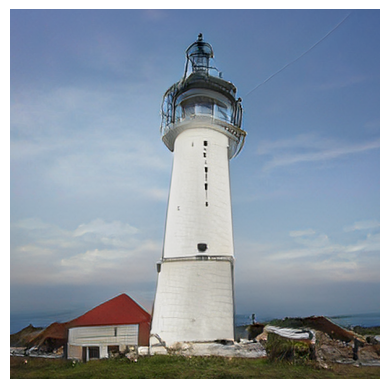

In [7]:
# Example from test set
img = gen_utils.w_to_img(G, torch.from_numpy(ws_te[93]).to(device), to_np=True)
img = Image.fromarray(gen_utils.create_image_grid(img), 'RGB')
plt.figure()
plt.imshow(img)
plt.axis("off")
plt.show()